In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("/home/anukoolpurohit/Documents/Workspace/Nueromatch/NMA-DL/HandwritingBCI")

# Imports

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import torch.nn.functional as F

In [5]:
from torch import nn
from scipy.io import loadmat
from torch.utils.data import Dataset, DataLoader, random_split

In [6]:
from handwritingBCI import Path
from handwritingBCI.data.utils.files import get_dataset
from handwritingBCI.data.datasets import NeuroDataset
from handwritingBCI.data.preprocessing import LabelEncoder
from handwritingBCI.plotting import plot_electrode_data

# Setup

## Seed

In [7]:
SEED = 42
np.random.seed(SEED)

## Data

In [8]:
PATH = Path("/home/anukoolpurohit/Documents/AnukoolPurohit/Datasets/HandwritingBCI/handwriting-bci/handwritingBCIData")

# Dataset and Dataloader

In [9]:
neuro_dataset = NeuroDataset.from_path(PATH)

In [10]:
train_dl, valid_dl = neuro_dataset.get_dataloaders(test_size=0.1,
                                                   batch_size=64,
                                                   generator=torch.Generator().manual_seed(SEED))

In [11]:
X, y = next(iter(train_dl))

## Visualization

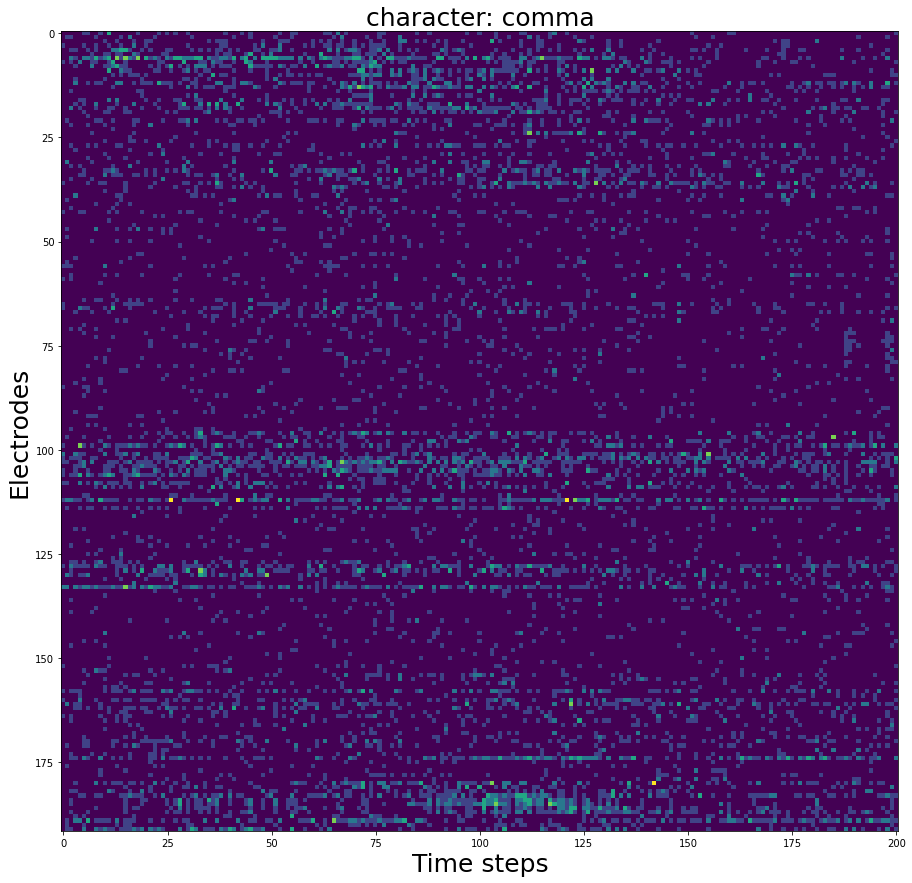

In [12]:
plot_electrode_data(X[0].squeeze(0), y[0],
                    deproc_label=neuro_dataset.target_transform.deprocess)

## Sample model

In [13]:
class Downsample(nn.Module):
    """
        Simple 2x2 conv with stride 2 and 0 padding to downsample instead of a maxpool
    """
    
    def __init__(self, input_channels: int) -> None:
        super().__init__()
        self.conv = nn.Conv2d(input_channels, input_channels,
                              kernel_size=2, stride=2, padding=0)
        self.relu = nn.ReLU()
        return
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        output = self.relu(x)
        return output
        

In [14]:
class ConvBlock(nn.Module):
    """
    Simple 3x3 conv with padding size 1 (to leave the input size unchanged),
    add a residual connection followed by a ReLU .
    """
    
    def __init__(self, input_channels:int, output_channels:int) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels,output_channels,
                               kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(output_channels)
        
        self.conv2 = nn.Conv2d(output_channels, output_channels,
                               kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU()
        return
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        """
        Parameters
        ----------
        x
            of dimensions (B, C, H, W)

        Returns
        -------
        torch.Tensor
            of dimensions (B, C, H, W)
        """
        c1 = self.conv1(x)
        c1 = self.bn1(c1)
        r1 = self.relu(c1)

        c2 = self.conv2(r1)
        c2 = self.bn2(c2)
        r2 = self.relu(c2 + x)
        return r2

In [15]:
class SimpleCNN(nn.Module):
    def __init__(self, input_shape:tuple, output_channels: int,
                 fc_dims: int, num_classes: int, block_num:int=2) -> None:
        super().__init__()
        assert len(input_shape) == 3
        input_channels = input_shape[0]
        
        self.conv_block1 = ConvBlock(input_channels, output_channels)
        self.conv_block2 = ConvBlock(output_channels, output_channels)
        self.downsample = Downsample(output_channels)
        
        input_fc_dims = output_channels * (input_shape[1]//2) * (input_shape[2]//2)
        
        self.fc1 = nn.Linear(input_fc_dims, fc_dims)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_dims, num_classes)
        return
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.downsample(x)
        x = x.flatten(1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
        

In [16]:
net = SimpleCNN((1, 201, 192), 64, 128, 31)

In [17]:
print(net(X).shape)

torch.Size([64, 31])


# Training Loop

In [18]:
import tqdm
from tqdm.auto import tqdm

In [19]:
epochs = 15
lr = 1e-3

In [20]:
model = SimpleCNN((1, 201, 192), 64, 128, 31)

In [21]:
train_dl, valid_dl = train_dl, valid_dl = neuro_dataset.get_dataloaders(test_size=0.1,
                                                   batch_size=32,
                                                   generator=torch.Generator().manual_seed(SEED))

In [22]:
model = model.cuda()

In [23]:
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

In [24]:
loss_func = nn.CrossEntropyLoss()
loss_func = loss_func.cuda()

In [25]:
train_losses = []
valid_losses = []

In [26]:
for epoch in tqdm(range(epochs)):
    model.train()
    epoch_train_losses = []
    for inputs, targets in tqdm(train_dl, leave=False):
        inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, targets)
        epoch_train_losses.append(loss.cpu().detach())
        loss.backward()
        optimizer.step()
    epoch_train_losses = torch.stack(epoch_train_losses)
    mean_epoch_train_loss = epoch_train_losses.mean()
    train_losses.append(mean_epoch_train_loss)
    
    model.eval()
    epoch_valid_losses = []
    with torch.no_grad():
        for inputs, targets in tqdm(valid_dl, leave=False):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            loss = loss_func(outputs, targets)
            epoch_valid_losses.append(loss.cpu().detach())
        epoch_valid_losses = torch.stack(epoch_valid_losses)
        mean_epoch_valid_loss = epoch_valid_losses.mean()
        valid_losses.append(mean_epoch_valid_loss)
            

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

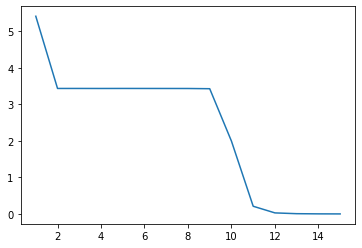

In [27]:
plt.plot(list(range(1, epochs+1)), train_losses)

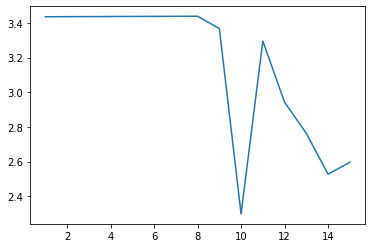

In [28]:
plt.plot(list(range(1, epochs+1)), valid_losses)

In [29]:
class Databunch:
    def __init__(self, train_dl, valid_dl, test_dl=None):
        self.train_dl = train_dl
        self.valid_dl = valid_dl
        self.test_dl = test_dl